# Forecasting analysis

In [312]:
import os
import itertools
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import datetime 
from datetime import timedelta
import math
import numpy as np
import scipy.stats as st
from prophet import Prophet
from influxdb_client import InfluxDBClient
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller


In [259]:

# Data extrapolation from Influx

INFLUXDB_HOST = os.getenv("INFLUX_HOST", "10.147.17.17")
INFLUXDB_PORT = os.getenv("INFLUXDB_PORT", "8086")
INFLUXDB_ORG = os.getenv("INFLUXDB_ORG", "lomo")
INFLUXDB_BUCKET = os.getenv("INFLUXDB_BUCKET", "lomo")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN", "adminadminadmin")

client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

In [299]:
def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_value(), record.get_time()))
    return pd.DataFrame(raw, columns=['y','ds'], index=None)

In [300]:
# Config with device id, the interval of time for the data used, evaluation start dates and the various field used 

device_id = '63206bf255cd6248f1a40184'

interval = 2
start_times =['2022-09-19T00:00', '2022-09-21T00:00', '2022-09-27T00:00']
fields = ['temp', 'hum', 'gas', 'soil']

In [301]:

#With this function we obtain the forecasted data

def evaluate_field(field):
    global mse_array
    global forecasted_array
    global expected_array
    global forecasted
    global expected
    mse_array = []
    forecasted_array = []
    expected_array = []
    forecasted = []
    expected = []
    
    for start_time in start_times:
        stop_time = datetime.datetime.strptime(start_time, "%Y-%m-%dT%H:%M")
        stop_time = (stop_time + datetime.timedelta(days=interval)).strftime("%Y-%m-%dT%H:%M")
        
        query = 'from(bucket: "lomo")' \
                ' |> range(start:' +  start_time+":00Z" + ', stop:' + stop_time+":00Z" + ')'\
                ' |> filter(fn: (r) => r["_measurement"] == "devices")' \
                ' |> filter(fn: (r) => r["_field"] == "' + field + '")' \
                ' |> filter(fn: (r) => r["id"] == "' + device_id +'")'
                
        result = client.query_api().query(org=INFLUXDB_ORG, query=query)
        # Convert the results to dataframe
        df = result_to_dataframe(result)
        df['ds'] = df['ds'].dt.tz_localize(None)

        #train_size 80% - test_size 20%

        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        m = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=30,
            n_changepoints=35,
            changepoint_range=1,
            changepoint_prior_scale=0.01
        ).fit(train)

        test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
        test_interval = test_interval + 5
        #print(test_interval)

        future = m.make_future_dataframe(periods=test_interval, freq= DateOffset(minutes=1))
        forecast = m.predict(future)

        forecast['ds'] = forecast.ds.dt.floor('min')
        test['ds'] = test.ds.dt.floor('min')
        metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()

        metric = metric.dropna()
        
        mse = mean_squared_error(metric['y'], metric['yhat'])
        mse_array.append(mse)
        
        expected_array.append(metric['y'].tolist())
        forecasted_array.append(metric['yhat'].tolist())
    
    

    forecasted = list(itertools.chain.from_iterable(forecasted_array))
    expected = list(itertools.chain.from_iterable(expected_array))

    
    

# evaluate_field('temp')
# print(mse_array)
# print(sum(mse_array)/len(mse_array))

20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] done processing
20:00:37 - cmdstanpy - INFO - Chain [1] start processing
20:00:37 - cmdstanpy - INFO - Chain [1] done processing




Evaluating temp


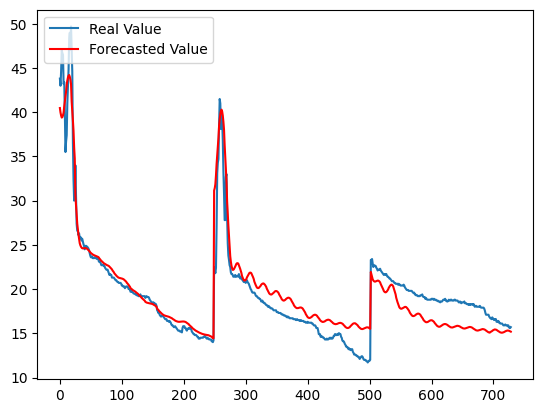

mse
4.618764550866899
Test RMSE: 2.149
MAE: 1.655737
Mean:  19.550517206965974
Standard Deviation:  5.825656897931894
Confidence intervals:  (19.126630362915453, 19.974404051016446)


C:\Users\barba\AppData\Local\Temp\ipykernel_5700\2984125910.py:80: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
20:00:40 - cmdstanpy - INFO - Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] done processing
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:48 - cmdstanpy - INFO - Chain [1] done processing




Evaluating hum


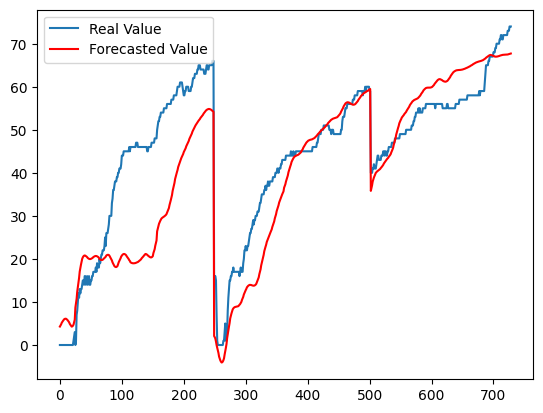

mse
125.79501190588088
Test RMSE: 11.216
MAE: 8.265723
Mean:  39.3534297102452
Standard Deviation:  20.276734805341594
Confidence intervals:  (37.878052551089745, 40.82880686940066)


C:\Users\barba\AppData\Local\Temp\ipykernel_5700\2984125910.py:80: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:52 - cmdstanpy - INFO - Chain [1] done processing
20:00:55 - cmdstanpy - INFO - Chain [1] start processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:58 - cmdstanpy - INFO - Chain [1] done processing




Evaluating gas


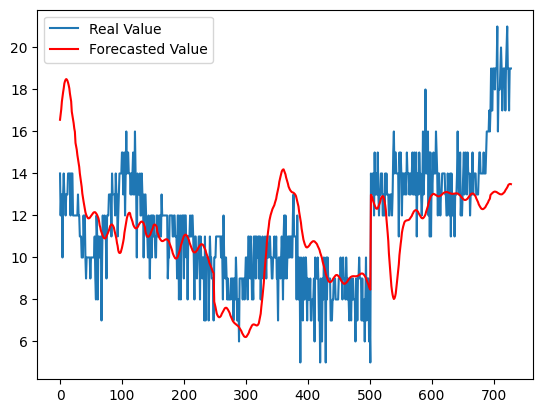

mse
6.738890822035954
Test RMSE: 2.596
MAE: 2.038048
Mean:  11.173466703026662
Standard Deviation:  2.306147841298194
Confidence intervals:  (11.005666616703571, 11.341266789349781)


C:\Users\barba\AppData\Local\Temp\ipykernel_5700\2984125910.py:80: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
20:01:02 - cmdstanpy - INFO - Chain [1] start processing
20:01:02 - cmdstanpy - INFO - Chain [1] done processing
20:01:05 - cmdstanpy - INFO - Chain [1] start processing
20:01:05 - cmdstanpy - INFO - Chain [1] done processing
20:01:09 - cmdstanpy - INFO - Chain [1] start processing
20:01:09 - cmdstanpy - INFO - Chain [1] done processing




Evaluating soil


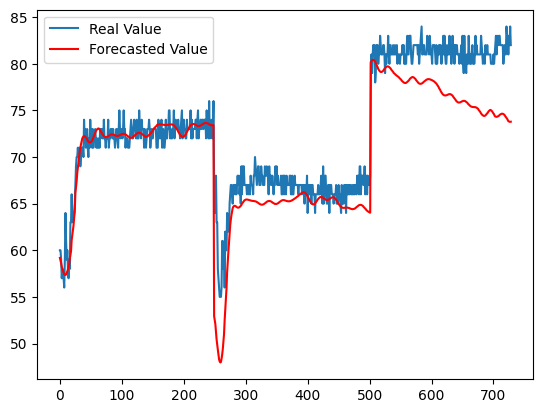

mse
12.26986516109674
Test RMSE: 3.503
MAE: 2.556086
Mean:  70.45257248576851
Standard Deviation:  6.464037812054818
Confidence intervals:  (69.9822357261582, 70.92290924537892)


C:\Users\barba\AppData\Local\Temp\ipykernel_5700\2984125910.py:80: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  res = st.t.interval(alpha=0.95, df=len(forecasted)-1,


In [313]:
APE = []
i = 0
for field in fields:
	evaluate_field(field)
	print("\n\nEvaluating " + field)
	plt.plot(expected, label="Real Value")
	plt.plot(forecasted, "-r", label="Forecasted Value")

	plt.legend(loc="upper left")
	plt.show()

	#Mean Square Error & Root Square Error considered more accurate 
	mse = mean_squared_error(expected, forecasted)
	print('mse')
	print(mse) #mah
	rmse = math.sqrt(mean_squared_error(expected, forecasted))
	print('Test RMSE: %.3f'%rmse)

	
	# MAE
	# The mean absolute error, or MAE, 
	# is calculated as the average of the forecast error values, 
	# where all of the forecast error values are forced to be positive.
	# These error values are in the original units of the predicted values. 
	# A mean absolute error of zero indicates no error.

	# Calculate the MAE 
	mae = mean_absolute_error(expected, forecasted)
	print('MAE: %f' % mae)


	# A confidence interval is an estimation technique used in statistical inference to constrain a pair or pairs of values, 
	# within which the desired point estimate will be found (with a certain probability).

	# A confidence interval will allow us to calculate two values around a sample mean (one upper and one lower). 
	# These values will bound an interval within which, with some probability, the population parameter will be found.


	mean = sum(forecasted) / len(forecasted) #mean
	print("Mean: ",mean)


	std = np.std(forecasted)  # standard deviation
	print("Standard Deviation: ",std)

	# create 95% confidence interval
	res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
				loc=np.mean(forecasted),
				scale=st.sem(forecasted))

	print("Confidence intervals: ",res)

